In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from ucimlrepo import fetch_ucirepo 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 
  
# metadata 
print(abalone.metadata) 
# variable information 
print(abalone.variables) 

# Combine features and targets into one DataFrame
df = pd.concat([X, y], axis=1)
df

{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [3]:
dataset = df[df.columns[0:7]]
dataset['Sex_1'] = np.where(dataset['Sex']=='M',1,-1)
dataset['Sex_2'] = np.where(dataset['Sex']=='F',1,-1)
dataset = dataset[dataset.columns[1:9]]
dataset

/var/folders/cw/lr079v3x42v2cctvdpqcgzgw0000gn/T/ipykernel_33831/3481993776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Sex_1'] = np.where(dataset['Sex']=='M',1,-1)


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Sex_1,Sex_2
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,1,-1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,1,-1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,-1,1
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,1,-1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,-1,-1
...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,-1,1
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,1,-1
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,1,-1
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,-1,1


In [4]:
dataset.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Sex_1,Sex_2
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,-0.268374,-0.374192
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.963430,0.927462
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,-1.000000,-1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,-1.000000,-1.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,-1.000000,-1.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,1.000000,1.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.000000,1.000000


In [5]:
dataset['Sex_1'] = pd.to_numeric(dataset['Sex_1'])
dataset['Sex_2'] = pd.to_numeric(dataset['Sex_2'])
# Normaliser les caractéristiques
#dataset[dataset.columns[0:7]] = (dataset[dataset.columns[0:7]] - dataset[dataset.columns[0:7]].mean()) / dataset[dataset.columns[0:7]].std()

train_X, test_X = train_test_split(
    dataset[dataset.columns[0:8]].values,
    test_size=0.2
)

# Conversion en tensors PyTorch
train_X = torch.tensor(train_X, dtype=torch.float32)
test_X = torch.tensor(test_X, dtype=torch.float32)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encodeur
        self.encoder = nn.Sequential(
            nn.Linear(8, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )
        # Décodeur
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 8),  # Taille de l'entrée
            nn.Sigmoid()
        )

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

In [7]:

autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
Perte = []
for epoch in range(5000):
    optimizer.zero_grad()
    output = autoencoder(train_X)
    loss = criterion(output, train_X)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 5000, loss.item()))
        
    Perte.append(loss.item())

# Test du modèle
with torch.no_grad():
    output = autoencoder(test_X)
    loss_test = criterion(output, test_X)
    print('Test Loss: {:.4f}'.format(loss_test.item()))

    reconstructed = output.numpy()
    original = test_X.numpy()

print('Mean Squared Error:', mean_squared_error(original, reconstructed))

Epoch [1/5000], Loss: 0.4815
Epoch [1001/5000], Loss: 0.2607
Epoch [2001/5000], Loss: 0.2606
Epoch [3001/5000], Loss: 0.2606
Epoch [4001/5000], Loss: 0.2605
Test Loss: 0.2606
Mean Squared Error: 0.26058322


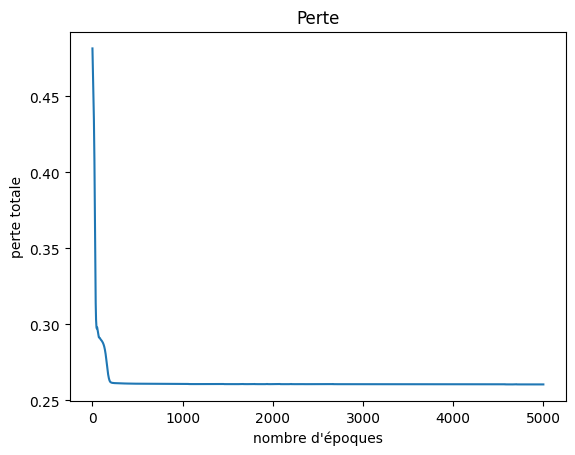

In [8]:
plt.plot(Perte)
plt.xlabel("nombre d'époques")
plt.ylabel("perte totale")
plt.title("Perte")
plt.show()

Avec encodage du Sex en 0,1,2 on avant 0,69 en perte
Avec l'encodage à 2 colonne en 1,-1 on a une perte à 0.2627